In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pylab as plt
import numpy as np
from mgemu import emu
import pyccl

In [4]:
def pmg(Om, h, ns, s8, fR0, n, z):
    Omh2 = (h**2)*Om
    pkratio, k = emu(Omh2, ns, s8, fR0, n, z)
    # cosmo = pyccl.Cosmology(Omega_c= Om, Omega_b=0.0, h=h, n_s=ns, sigma8=s8, transfer_function='bbks')
    cosmo = pyccl.Cosmology(Omega_c=Om-0.02203/(h**2), Omega_b=0.02203/(h**2), h=h, sigma8=s8, n_s=ns, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    a = 1./(1+z)
    #Now we have to be careful, because mgemu k-units are in h/Mpc, while CCL units are in 1/Mpc. convert
    kccl = k*h
    pk_nl = pyccl.nonlin_matter_power(cosmo, kccl, a)
    #CCL output pk is in Mpc^3, convert to (Mpc/h)^3
    pk_nl *= h*h*h
    #pk_mg = pk_lcdm*pkratio
    pk_mg = pk_nl*pkratio
    return pk_mg, k

In [5]:
#Defining function to calculate galaxy power spectrum, using the matter Pk from function pmg
#Additional arguments needed are linear bias b1& snot noise term shot
def p_ggmg(Om, h, ns, s8, fR0, n, z, b1, shot):
    Omh2 = (h**2)*Om
    pkratio, k = emu(Omh2, ns, s8, fR0, n, z)
    cosmo = pyccl.Cosmology(Omega_c=Om-0.02203/(h**2), Omega_b=0.02203/(h**2), h=h, sigma8=s8, n_s=ns, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    a = 1./(1+z)
    #Now we have to be careful, because mgemu k-units are in h/Mpc, while CCL units are in 1/Mpc. convert k-emu range
    kccl = k*h
    pk_nl = pyccl.nonlin_matter_power(cosmo, kccl, a)
    #CCL output pk is in Mpc^3, convert to (Mpc/h)^3
    pk_nl *= h*h*h
    #pk_mg = pk_lcdm*pkratio
    pk_mg = pk_nl*pkratio
    pgg_mg = b1*b1*pk_mg + shot
    return pgg_mg, k

In [6]:
### LCDM parameters
h=0.6774 # See README and the accompanying paper regarding the value of h. 
Om = 0.3089
Omh2=(h**2)*Om
Obh2 = 0.02203
Och2 = Omh2-Obh2
ns=0.9667
s8=0.8159
### Hu-Sawicki model parameters
fr0=1e-5
n=1
### Redshift
z=0.0

In [7]:
pkratio, k = emu(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=n, z=z)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [8]:
# cosmo = pyccl.Cosmology(Omega_c= Om, Omega_b=0.0, h=h, n_s=ns, sigma8=s8, transfer_function='bbks')
cosmo = pyccl.Cosmology(Omega_c=Och2/(h**2), Omega_b=Obh2/(h**2), h=h, sigma8=s8, n_s=ns, Neff=3.04, transfer_function='bbks', matter_power_spectrum='emu')
#pyccl.comoving_radial_distance(cosmo, 1./(1+z))
a = 1./(1+z)
pk_lcdm = pyccl.nonlin_matter_power(cosmo, k*h, a)
pk_lcdm *= h*h*h

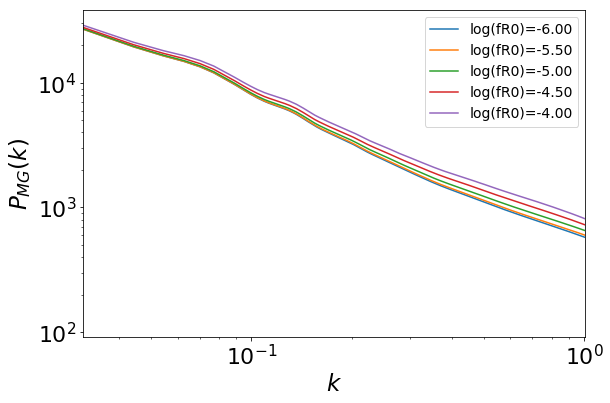

In [9]:
import matplotlib.pylab as plt
import numpy as np

plt.figure(1, figsize=(9, 6) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
b1 =1.2
shot = 10.0
for i in range(5):
    fR0 = fR0_arr[i]
    #p_mg, k = pmg(Om, h, ns, s8, fR0, n, z)
    p_gg, k = p_ggmg(Om, h, ns, s8, fR0, n, z, b1, shot)
    #plt.plot(k, p_mg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
    plt.plot(k, p_gg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$P_{MG}(k)$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(fontsize=14)
plt.xlim(0, 1.01)
#plt.ylim(1e3,)


plt.show()

In [10]:
#Now that we can evalute the galaxy Pk for a given MG cosmology, let's build functions to actually predict the galaxy bias and shot noise for a realistic LSST sample 

In [11]:
import math
from scipy.interpolate import interp1d
from scipy.integrate import quad, dblquad
from scipy.special import gamma
from scipy.integrate import odeint

In [12]:
#Define a-dependent functions for growth factor equation
def Omegatime(a, Om0):
 return Om0/(Om0+(1-Om0)*a*a*a)
#adot
def adot(a, Om0):
 return np.sqrt(Om0/a+(1-Om0)*a*a)
def H(a, Om0):
 return adot(a, Om0)/a
def adotprime(a, Om0):
 return (-Om0/a/a + 2*(1-Om0)*a)/np.sqrt(Om0/a+(1-Om0)*a*a)/2
#Define additional functions needed for
def mfr(a, Om0, fr0, nfr): #scalar field mass
 return (1/2997.72)*math.sqrt(1./(nfr+1)/fr0)*math.sqrt(math.pow(Om0+4*(1-Om0),-nfr-1))*math.sqrt(math.pow(Om0/a/a/a+4*(1-Om0),2+nfr))
#Define 1/adot^3 integrand
def invadot3(a, Om0):
 return 1/adot(a, Om0)/adot(a, Om0)/adot(a, Om0)
#Define 1/adot^3 integral
def intToday(Om0, amin):
 return quad(invadot3,0,amin,args=(Om0))[0]
def Damin(Om0, amin):
 return 2.5*Om0*H(amin, Om0)*intToday(Om0, amin)
def DH1(a, Om0):
 return -3*Om0/(2*a*a*a*math.sqrt((a*a*a+Om0-Om0*a*a*a)/a))
def der0(Om0, amin):
 return 2.5*Om0*(DH1(amin, Om0)*intToday(Om0, amin)+H(amin, Om0)*invadot3(amin, Om0))

In [13]:
#Setup integration to get comoving volume for various z bin
#Comoving distance integrator
def integrand(a, Omm):
 return 1/math.sqrt(a*Omm+a*a*a*a*(1-Omm))
#get comoving volume
def Vcom(z, Omm):
 return (4*math.pi*20000)/(3*41252.96)*math.pow(2997.92458*quad(integrand, 1./(1+z), 1, args=(Omm))[0],3)#*math.pow(10,-9)
#get comoving differential volume in redshift bin with width +-0.05
def Vbin(z, Omm, bin):
 return Vcom(z+bin, Omm)-Vcom(z-bin, Omm)
Veff=np.vectorize(Vbin)

#Define function fro differential dN/dz to be integrated
def dNdz(z, alpha, z0, ntot):
 return (ntot*alpha/(z0*gamma(3.0/alpha)))*(z/z0)*(z/z0)*math.exp(-math.pow(z/z0,alpha))
def Nz(z, alpha, z0, ntot, bin):
 return quad(dNdz, z-bin, z+bin, args=(alpha, z0, ntot))[0]

In [14]:
#Setup basic parameters for year10&Y1 LSST photo-z samples
NY10=48*20000*3600
ay10= 0.90
z0y10 = 0.28
biny10 = 0.05
b1y10 = 0.95
#for year1 sample
NY1=18*20000*3600
ay1= 0.94
z0y1 = 0.26
biny1 = 0.1
b1y1 = 1.05

In [15]:
abserr = 1.0e-13
relerr = 1.0e-13
#Define growth factor differential equation system
def growth(y, a, Om0):
 D, w = y
 dyda = [w, -(adotprime(a, Om0) + 2*H(a, Om0))*w/adot(a, Om0) + 1.5*Omegatime(a, Om0)*H(a, Om0)*H(a, Om0)*D/adot(a, Om0)/adot(a, Om0)]
 return dyda
 
#y0 = [0.0019999999,0.999999999]
arange = np.logspace(math.log(0.002,10),math.log(1,10),1000)
#setting up boundary conditions
y0 = [Damin(Om, arange[0]),der0(Om, arange[0])]
sol = odeint(growth, y0, arange, args=(Om,), atol=abserr, rtol=relerr)
#Spline GR growth factor  solution and growth rate.
Dgr = interp1d(arange, sol[:,0], kind='cubic')
#and also growth rate
fgr = interp1d(arange, arange*sol[:,1]/sol[:,0], kind='cubic')

In [16]:
timesteps = np.loadtxt('timestepsCOLA.txt')
irangey10 = np.array([43,45,48,53,57,61,65,70,75,82])
irangey1 = np.array([43,48,57,65,75])
Nt = irangey10[irangey10.shape[0]-1]

Nseed=2000 #25

In [17]:
#Now iterate of different snapshots
for i in (irangey10):
 astep = timesteps[i,0]
 zstep = timesteps[i,1]
 #linear bias for galaxy sample, in our case Y10
 b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
 #b1=b1y1*Dgr(1)/Dgr(astep) #Bias for Y10
 print ('a,z,b_1=',astep, zstep, b1)

a,z,b_1= 0.4512 1.216313 1.7096583337348537
a,z,b_1= 0.4708 1.124045 1.645654696216662
a,z,b_1= 0.5002 0.999201 1.5599659653732123
a,z,b_1= 0.5492 0.820831 1.439767025161971
a,z,b_1= 0.5884 0.699524 1.359885641811489
a,z,b_1= 0.6276 0.593372 1.2915087247085706
a,z,b_1= 0.6668 0.4997 1.232567867300583
a,z,b_1= 0.7158 0.397038 1.169726499808988
a,z,b_1= 0.7648 0.307531 1.1166678302825346
a,z,b_1= 0.8334 0.199904 1.0553364364635174


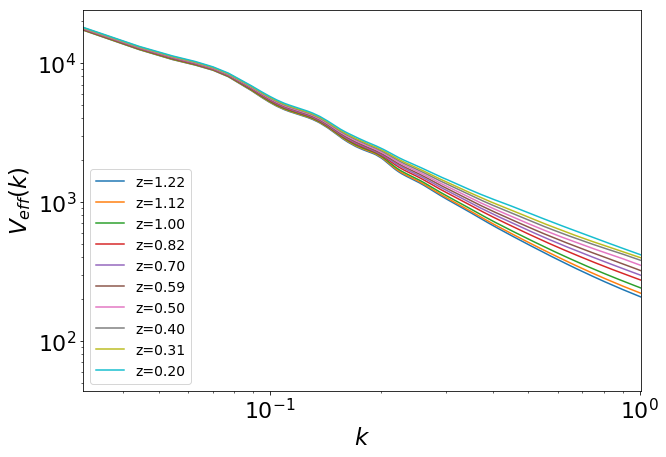

In [18]:
#Evaluate and Plot P_gg for 10 snapshots of the Y10 galaxy sample
plt.figure(1, figsize=(10, 7) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
#b1 =1.2
#shot = 10.0
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    p_gg, k = p_ggmg(Om, h, ns, s8, fR0, n, zstep, b1, shot)
    #plt.plot(k, p_mg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
    plt.plot(k, p_gg, label = "z={:.2f}".format(zstep) )
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$V_{eff}(k)$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(fontsize=14)
plt.xlim(0, 1.01)
#plt.ylim(1e3,)


plt.show()

In [19]:
#print (Nseed, k.shape[0],((Nseed-k.shape[0]-2)/(Nseed-1)))
#Import covariance matrices
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    locals()['covPMGmat_'+str(i)] = np.loadtxt('./Covariance_data/covariance_step_'+str(i)+'.txt')
    locals()['InvcovPMGmat_'+str(i)] = ((Nseed-k.shape[0]-2)/(Nseed-1))*np.linalg.inv(locals()['covPMGmat_'+str(i)])

In [20]:
kvec = k
def applyPlotStyle14():
 plt.tick_params(axis='both',which='major',length=5, left='on', right='on', width=1, direction='inout')
 plt.tick_params(axis='both',which='minor',length=3.2,left='on', right='on', width=1, direction='inout')
 plt.tick_params(which='both',width=1.3)
 plt.grid(True)
 plt.xscale("log")
 plt.yscale("log")
 plt.xlim(kvec[0], kvec[kvec.shape[0]-1])
 plt.ylim(kvec[0], kvec[kvec.shape[0]-1])
 #plt.ylabel(r"$\frac{P_{MG}}{P_{\Lambda CDM}}$",fontsize=18)
 plt.xlabel(r"$k (h/Mpc)$",fontsize=18)
 plt.ylabel(r"$k (h/Mpc)$",fontsize=18)
 #plt.ylabel(r"$r (Mpc/h)$",fontsize=18)
 plt.legend(loc="best", frameon=False, numpoints=1, prop={'size':12})

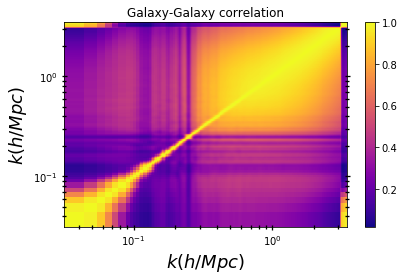

In [21]:
#Get correlation matrix for step=43
covxx = np.sqrt(np.diag(covPMGmat_82))*np.identity(len(kvec))
invcoxx = np.linalg.inv(covxx)
corrPMGmat_43 = np.dot(invcoxx,np.dot(covPMGmat_82,invcoxx))
import scipy.ndimage as scim
sigma_x = sigma_y = 2.0
sigma = [sigma_y, sigma_x]
cov_mat2 = scim.filters.gaussian_filter(covPMGmat_82, sigma, mode='wrap')
covxxsmopth = np.sqrt(np.diag(cov_mat2))*np.identity(len(kvec))
invcov_mat2 = np.linalg.inv(covxxsmopth)
corr_mat2 = np.dot(invcov_mat2,np.dot(cov_mat2,invcov_mat2))
from matplotlib import gridspec
from matplotlib import cm
fig11=plt.figure('test')
ax=fig11.add_subplot(111)
applyPlotStyle14()
ax.set_title('Galaxy-Galaxy correlation')
#pltcov=ax.pcolormesh(kvec,kvec,covPMGmat_43, cmap='plasma')
#pltcov=ax.pcolormesh(kvec,kvec,corrPMGmat_43, cmap='plasma')
pltcov=ax.pcolormesh(kvec,kvec,corr_mat2, cmap='plasma')
fig11.colorbar(pltcov, ax=ax)
plt.tight_layout()
plt.show()

In [22]:
npar = 6 #no of paramaters to constrain
FY10tot = np.zeros([npar,npar])
FY1tot = np.zeros([npar,npar])
#imax =  60 #135 #maximum k scale array index
imax = 21

In [23]:
#Setup integration to get Fisher matrix using Tegmark's analytical formula
#Integrand
#def integrandFisher(kk, derD1, derD2, D, kvec):
 #construct splines of vectors, to make integrator happy
# der1int = interp1d(kvec, derD1, kind='cubic')
# der2int = interp1d(kvec, derD2, kind='cubic')
# Pfidint = interp1d(kvec, D, kind='cubic')    
# return kk*kk*der1int(kk)*der2int(kk)/Pfidint(kk)/Pfidint(kk)
#integrandFisher = np.vectorize(integrandFisher)
#Quadrature
#def Fisher_gaussian(derD1, derD2, D, kvec, imax):
# return quad(integrandFisher, kvec[0], kvec[imax], args=(derD1, derD2, D, kvec))[0]#*math.pow(10,-9)
#Fisher_gaussian = np.vectorize(Fisher_gaussian)
print (kvec[0:imax])

[0.0312147  0.0442523  0.054388   0.06273525 0.07010365 0.0771044
 0.08893805 0.0947648  0.099384   0.10422835 0.10930885 0.1128327
 0.11833265 0.1260851  0.1301498  0.1343455  0.1364938  0.14089405
 0.14314705 0.14776175 0.15496425]


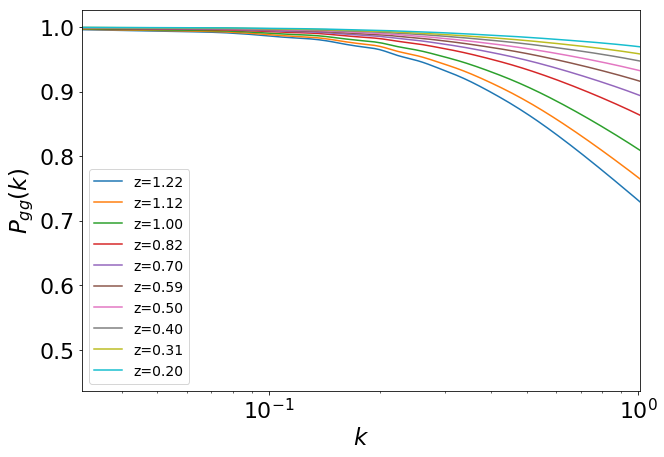

In [24]:
plt.figure(1, figsize=(10, 7) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
#b1 =1.2
#shot = 10.0
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    Pfid, kkk = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1, Shot)
    nlit = 1.0/Shot
    plt.plot(kkk, (nlit*Pfid)*(nlit*Pfid)/(1.0+nlit*Pfid)/(1.0+nlit*Pfid), label = "z={:.2f}".format(zstep) )
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r'$P_{gg}(k)$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(fontsize=14)
plt.xlim(0, 1.01)
#plt.ylim(1e3,)


plt.show()

In [25]:
#Calculating derivatives for Y10 sample
#for i in (irangey10):
Omstep = 0.003
s8step = 0.05 #0.05
nsstep = 0.03 #0.025
fr0step = fr0*0.1
nstep = 0.1*n
b1step=0.01
#for i in range(82,83):
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    ndens = 1.0/Shot
    Pfid, kkk = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1, Shot)
    Pfidint = interp1d(kkk, Pfid, kind='cubic')
    Vol = Veff(zstep, Om, biny10)
    #Start with Omh2 derivatives
    Omh2up = Omh2 + Omstep
    Omh2down = Omh2 - Omstep
    Omup = Omh2up/h/h
    Omdown = Omh2down/h/h
    #Now we need to be careful. When Om changes, growth factor and Volume change, -> bias&shot noise change
    y0up = [Damin(Omup, arange[0]),der0(Omup, arange[0])]
    solup = odeint(growth, y0up, arange, args=(Omup,), atol=abserr, rtol=relerr)
    #Spline GR growth factor  solution and growth rate.
    Dgrup = interp1d(arange, solup[:,0], kind='cubic')
    b1up=b1y10*Dgrup(1)/Dgrup(astep)
    Shotup = Veff(zstep, Omup, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    p_ggup, k = p_ggmg(Omup, h, ns, s8, fr0, n, zstep, b1up, Shotup)
    #Do same for down
    y0down = [Damin(Omdown, arange[0]),der0(Omdown, arange[0])]
    soldown = odeint(growth, y0down, arange, args=(Omdown,), atol=abserr, rtol=relerr)
    #Spline GR growth factor  solution and growth rate.
    Dgrdown = interp1d(arange, soldown[:,0], kind='cubic')
    b1down=b1y10*Dgrdown(1)/Dgrdown(astep)
    Shotdown = Veff(zstep, Omdown, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    p_ggdown, k = p_ggmg(Omdown, h, ns, s8, fr0, n, zstep, b1down, Shotdown)
    #And evaluate derivative
    derOmh = (p_ggup-p_ggdown)/2/Omstep
    #dertot array for all derivatives to be stacked
    dertot = derOmh
    #print (derOmh)
    #Now move on to sigma_8
    s8up = s8 + s8step
    p_ggup, k = p_ggmg(Om, h, ns, s8up, fr0, n, zstep, b1, Shot)
    s8down = s8 - s8step
    p_ggdown, k = p_ggmg(Om, h, ns, s8down, fr0, n, zstep, b1, Shot)
    #derivative
    ders8 = (p_ggup-p_ggdown)/2/s8step
    dertot = np.vstack((dertot,ders8))
    #print (dertot.shape)
    #Now move on to n_s
    nsup = ns + nsstep
    p_ggup, k = p_ggmg(Om, h, nsup, s8, fr0, n, zstep, b1, Shot)
    nsdown = ns - nsstep
    p_ggdown, k = p_ggmg(Om, h, nsdown, s8, fr0, n, zstep, b1, Shot)
    derns = (p_ggup-p_ggdown)/2/nsstep
    dertot = np.vstack((dertot,derns))
    #print (dertot.shape)  
    #Now move on to fr0
    fr0up = fr0 + fr0step
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0up, n, zstep, b1, Shot)
    fr0down = fr0 - fr0step
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0down, n, zstep, b1, Shot)
    derfr = fr0*(p_ggup-p_ggdown)/2/fr0step
    dertot = np.vstack((dertot,derfr)) 
    #print (dertot.shape)
    #Now move on to n
    nup = n + nstep
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0, nup, zstep, b1, Shot)
    ndown = n - nstep
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0, ndown, zstep, b1, Shot)
    dern = (p_ggup-p_ggdown)/2/nstep
    dertot = np.vstack((dertot,dern)) 
    #print (dertot.shape)
    #Finally, do nuissance parameter b_1
    b1up = b1 + b1step
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1up, Shot)
    b1down = b1 - b1step
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1down, Shot)
    derb = (p_ggup-p_ggdown)/2/b1step
    dertot = np.vstack((dertot,derb))    
    #print (dertot.shape)
    #print (dertot)
    #Now that all the derivatives have been evaluated, it's time to import the covariance matrix for given z-snapshot
    #covPMGmatz = np.loadtxt('./Covariance_data/covariance_step_'+str(i)+'.txt')
    #InvcovPMGmatz = ((Nseed-kvec.shape[0]-2)/(Nseed-1))*np.linalg.inv(covPMGmatz)[0:imax,0:imax]
    #Diagonal approximation, temporary test
    #covPMGmatz = np.diag(covPMGmat_82)*np.identity(len(kvec))
    #InvcovPMGmatz = np.linalg.inv(covPMGmatz[0:imax,0:imax])
    dertot = dertot.T 
    #loop over all parameters to populate it    
    for ii in range(npar):
      for jj in range(npar):
        #FY10tot[ii,jj] += np.dot(dertot[0:imax,ii],np.dot(InvcovPMGmatz,dertot[0:imax,jj]))
        #Analytical approximation
        der1int = interp1d(kvec, dertot[:,ii], kind='cubic')
        der2int = interp1d(kvec, dertot[:,jj], kind='cubic')         
        def integrandFisher(kk):
         #construct splines of vectors, to make integrator happy 
         Vk = (ndens*Pfidint(kk))*(ndens*Pfidint(kk))/(1.0 + ndens*Pfidint(kk))/(1.0 + ndens*Pfidint(kk))
         return kk*kk*der1int(kk)*der2int(kk)*Vk/Pfidint(kk)/Pfidint(kk)
        integrandFisher = np.vectorize(integrandFisher) 
        def Fisher_gaussian(imax):
         return quad(integrandFisher, kvec[0], kvec[imax])[0]#*math.pow(10,-9)
        Fisher_gaussian = np.vectorize(Fisher_gaussian)
        FY10tot[ii,jj] += Vol*Fisher_gaussian(imax)/4/math.pi/math.pi

In [26]:
#dertot = dertot.T
#print (dertot[:,0].shape)
#print (dertot)
#FisheTest = np.dot(dertot[:,3],np.dot(InvcovPMGmat_43,dertot[:,3]))
#print (k[0:60])
print (np.sqrt(np.linalg.inv(FY10tot)[3,3]))
#print (np.linalg.inv(FY10tot)[3,3])
#covPMGmatztest = np.loadtxt('./Covariance_data/covariance_step_43.txt')
#Inv1 = np.linalg.inv(covPMGmatztest[0:imax,0:imax])
#Inv2 = np.linalg.inv(covPMGmatztest)[0:imax,0:imax]
#print (Inv1/Inv2)
#print (((Nseed-k.shape[0]-2)/(Nseed-1))/((Nseed-60-2)/(Nseed-1)))
#print ((Nseed-imax-2)/(Nseed-1))

0.6222841455081789


In [ ]:
fig = plt.figure('dertest')
print (zstep)
fr0up = fr0 + fr0step
#p_ggup, k = p_ggmg(Om, h, ns, s8, fr0up, n, zstep, b1, Shot)
fr0down = fr0 - fr0step
#p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0down, n, zstep, b1, Shot)
#plt.loglog(k, p_ggup, color='r')
#plt.loglog(k, p_ggdown, color='r')
plt.semilogx(k,dertot[:,4])
plt.semilogx(k,dertot[:,4])
plt.show()

In [ ]:
fig = plt.figure('frtest')
#zstep = 
fr0stepint = fr0*0.01
fr0up = fr0 + fr0stepint
#p_ggup, k = p_ggmg(Om, h, ns, s8, fr0up, n, zstep, b1, Shot)
fr0down = fr0 - fr0stepint
#p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0down, n, zstep, b1, Shot)
astep = 1./(1+zstep)
pk_lcdm = pyccl.nonlin_matter_power(cosmo, k*h, astep)
pk_lcdm *= h*h*h
#plt.loglog(k, p_ggup, color='r')
#plt.loglog(k, p_ggdown, color='b')
#plt.semilogx(k,fr0*(p_ggup-p_ggdown)/(fr0stepint*2))
#plt.semilogx(k,(p_ggup/p_ggdown))
plt.semilogx(k,(p_ggdown/pk_lcdm))
#plt.semilogx(k,dertot[:,3])
plt.show()

In [27]:
np.savetxt('./Covariance_data/FisherzY10analk015.txt', FY10tot)

In [ ]:
#Repeating previous calculation for Y1 sample
Omstep = 0.003
s8step = 0.05 #0.05
nsstep = 0.03 #0.025
fr0step = fr0*0.1
nstep = 0.1*n
b1step=0.01
#for i in range(43,44):
for i in (irangey1):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y1
    b1=b1y1*Dgr(1)/Dgr(astep) #Bias for Y1
    Shot = Veff(zstep, Om, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
    Pfid, kkk = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1, Shot)
    Pfidint = interp1d(kkk, Pfid, kind='cubic')
    Vol = Veff(zstep, Om, biny1)
    #Start with Omh2 derivatives
    Omh2up = Omh2 + Omstep
    Omh2down = Omh2 - Omstep
    Omup = Omh2up/h/h
    Omdown = Omh2down/h/h
    #Now we need to be careful. When Om changes, growth factor and Volume change, -> bias&shot noise change
    y0up = [Damin(Omup, arange[0]),der0(Omup, arange[0])]
    solup = odeint(growth, y0up, arange, args=(Omup,), atol=abserr, rtol=relerr)
    #Spline GR growth factor  solution and growth rate.
    Dgrup = interp1d(arange, solup[:,0], kind='cubic')
    b1up=b1y1*Dgrup(1)/Dgrup(astep)
    Shotup = Veff(zstep, Omup, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
    p_ggup, k = p_ggmg(Omup, h, ns, s8, fr0, n, zstep, b1up, Shotup)
    #Do same for down
    y0down = [Damin(Omdown, arange[0]),der0(Omdown, arange[0])]
    soldown = odeint(growth, y0down, arange, args=(Omdown,), atol=abserr, rtol=relerr)
    #Spline GR growth factor  solution and growth rate.
    Dgrdown = interp1d(arange, soldown[:,0], kind='cubic')
    b1down=b1y1*Dgrdown(1)/Dgrdown(astep)
    Shotdown = Veff(zstep, Omdown, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
    p_ggdown, k = p_ggmg(Omdown, h, ns, s8, fr0, n, zstep, b1down, Shotdown)
    #And evaluate derivative
    derOmh = (p_ggup-p_ggdown)/2/Omstep
    #dertot array for all derivatives to be stacked
    dertot = derOmh
    #print (derOmh)
    #Now move on to sigma_8
    s8up = s8 + s8step
    p_ggup, k = p_ggmg(Om, h, ns, s8up, fr0, n, zstep, b1, Shot)
    s8down = s8 - s8step
    p_ggdown, k = p_ggmg(Om, h, ns, s8down, fr0, n, zstep, b1, Shot)
    #derivative
    ders8 = (p_ggup-p_ggdown)/2/s8step
    dertot = np.vstack((dertot,ders8))
    #print (dertot.shape)
    #Now move on to n_s
    nsup = ns + nsstep
    p_ggup, k = p_ggmg(Om, h, nsup, s8, fr0, n, zstep, b1, Shot)
    nsdown = ns - nsstep
    p_ggdown, k = p_ggmg(Om, h, nsdown, s8, fr0, n, zstep, b1, Shot)
    derns = (p_ggup-p_ggdown)/2/nsstep
    dertot = np.vstack((dertot,derns))
    #print (dertot.shape)  
    #Now move on to fr0
    fr0up = fr0 + fr0step
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0up, n, zstep, b1, Shot)
    fr0down = fr0 - fr0step
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0down, n, zstep, b1, Shot)
    derfr = fr0*(p_ggup-p_ggdown)/2/fr0step
    dertot = np.vstack((dertot,derfr)) 
    #print (dertot.shape)
    #Now move on to n
    nup = n + nstep
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0, nup, zstep, b1, Shot)
    ndown = n - nstep
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0, ndown, zstep, b1, Shot)
    dern = (p_ggup-p_ggdown)/2/nstep
    dertot = np.vstack((dertot,dern)) 
    #print (dertot.shape)
    #Finally, do nuissance parameter b_1
    b1up = b1 + b1step
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1up, Shot)
    b1down = b1 - b1step
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1down, Shot)
    derb = (p_ggup-p_ggdown)/2/b1step
    dertot = np.vstack((dertot,derb))    
    #print (dertot.shape)
    #print (dertot)
    #Now that all the derivatives have been evaluated, it's time to import the covariance matrix for given z-snapshot
    #covPMGmatz = np.loadtxt('./Covariance_data/covarianceY1_step_'+str(i)+'.txt')
    #InvcovPMGmatz = ((Nseed-k.shape[0]-2)/(Nseed-1))*np.linalg.inv(covPMGmatz)[0:imax,0:imax]
    dertot = dertot.T
    for ii in range(npar):
      for jj in range(npar):
        #FY10tot[ii,jj] += np.dot(dertot[0:imax,ii],np.dot(InvcovPMGmatz,dertot[0:imax,jj]))
        #Analytical approximation
        der1int = interp1d(kvec, dertot[:,ii], kind='cubic')
        der2int = interp1d(kvec, dertot[:,jj], kind='cubic')         
        def integrandFisher(kk):
         #construct splines of vectors, to make integrator happy   
         return kk*kk*der1int(kk)*der2int(kk)/Pfidint(kk)/Pfidint(kk)
        integrandFisher = np.vectorize(integrandFisher) 
        def Fisher_gaussian(imax):
         return quad(integrandFisher, kvec[0], kvec[imax])[0]#*math.pow(10,-9)
        Fisher_gaussian = np.vectorize(Fisher_gaussian)
        FY1tot[ii,jj] += Vol*Fisher_gaussian(imax)/4/math.pi/math.pi

In [ ]:
np.savetxt('./Covariance_data/FisherzY1analk03.txt', FY1tot)

In [ ]:
print (FY1tot)

In [ ]:
h_l = 0.67
Om_l = 0.3000
Omb_l = 0.0260
s8_l = 0.8200
ns_l=0.9600
print (Om_l-Omb_l)
#a = 1./(1+z)
#Now we have to be careful, because mgemu k-units are in h/Mpc, while CCL units are in 1/Mpc. convert
#kccl = k*h
#pk_nl = pyccl.nonlin_matter_power(cosmo, kccl, a)


In [ ]:
kl, Pk97 = np.loadtxt('/Users/gev866/Downloads/Pk_97.txt', unpack=True)
kl, Pk71 = np.loadtxt('/Users/gev866/Downloads/Pk_71.txt', unpack=True)
kl, Pk36 = np.loadtxt('/Users/gev866/Downloads/Pk_36.txt', unpack=True)
#print (kl, Pk97)
a97=1.0/(1.0+0.019)
#cosmo_l = pyccl.Cosmology(Omega_c=Om_l-Omb_l, Omega_b=Omb_l, h=h_l, sigma8=s8_l, n_s=ns_l, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
pk_emu = pyccl.nonlin_matter_power(cosmo, kl, a97)

In [ ]:
plt.figure('testing', figsize=(10, 7) )
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('COLA simulations')
plt.plot(kl/h_l, Pk97, label = r'$z=0.02$', color='b')
plt.plot(kl/h_l, Pk71, label = r'$z=0.38$', color='r')
plt.plot(kl/h_l, Pk36, label = r'$z=1.62$', color='g')
plt.plot(kl/h_l, pk_emu*h_l*h_l*h_l, label = 'CosmicEmu', color='c')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$P_{m}(k)$', fontsize=23)
plt.xlabel(r'$k$ (h/Mpc)', fontsize=23)
plt.legend(fontsize=14)
#plt.xlim(0.035, 3.5)
#plt.ylim(1e3,)
plt.show()